# Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns
from outputs.charts.markowitz_plot import plot_time_serie, plot_efficient_frontier, markowitz_tradeoff, plot_comparison_time_series, find_lambda_for_target
from src.optimization.sharpe import maximize_sharpe
from src.optimization.markowitz import minimize_volatility, portfolio_return, portfolio_volatility, solve_markowitz
from src.data.loader import converter_periodo

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# User input

In [2]:
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"] # "MGLU3.SA"
start_date = "2017-01-01"
end_date = "2023-01-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
#frequencia_retorno = 'monthly'
#target_return = 0.01
risk_free_rate = 0.15

# Levantando estatística dos dados

In [3]:


prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')
returns_monthly = compute_returns(prices, freq='monthly')
returns_annually = compute_returns(prices, freq='annually')

mean_returns_daily = returns_daily.mean()
cov_matrix_daily = returns_daily.cov()

mean_returns_monthly = returns_monthly.mean()
cov_matrix_monthly = returns_monthly.cov()

mean_returns_annually = returns_annually.mean()
cov_matrix_annually = returns_annually.cov()

/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [4]:
print(mean_returns_daily)
print(mean_returns_annually)

Ticker
ABEV3.SA    0.000230
B3SA3.SA    0.001046
BBAS3.SA    0.000731
BBDC4.SA    0.000414
GGBR4.SA    0.001257
ITUB4.SA    0.000485
PETR4.SA    0.001295
VALE3.SA    0.001449
WEGE3.SA    0.001596
dtype: float64
Ticker
ABEV3.SA   -0.025513
B3SA3.SA    0.230303
BBAS3.SA    0.130016
BBDC4.SA    0.005348
GGBR4.SA    0.264426
ITUB4.SA    0.056111
PETR4.SA    0.279593
VALE3.SA    0.279681
WEGE3.SA    0.448367
dtype: float64


In [5]:
#weights_markowitz_daily = minimize_volatility(mean_returns_daily, cov_matrix_daily)
#weights_markowitz_monthly = minimize_volatility(mean_returns_monthly, cov_matrix_monthly)

weights_markowitz_daily =  solve_markowitz(mean_returns_daily, cov_matrix_daily, lamb=1)
weights_markowitz_monthly = solve_markowitz(mean_returns_monthly, cov_matrix_monthly, lamb=1)
#weights_markowitz_annual = solve_markowitz(mean_returns_annually, cov_matrix_annually, lamb=1)


In [6]:
# necesario ajustar (esta fixado em diario)
from src.data.loader import ajustar_risk_free


risk_free_rate_annual = 0.15

risk_free_rate_daily = ajustar_risk_free(risk_free_rate_annual, 'daily')
risk_free_rate_monthly = ajustar_risk_free(risk_free_rate_annual, 'monthly')

weights_sharpe = maximize_sharpe(mean_returns_daily, cov_matrix_daily, risk_free_rate=risk_free_rate_daily)
# ver sahrpe para mensal e anual depois

In [7]:
df_pesos = pd.DataFrame({
    "Ticker": tickers,
    "Peso Markowitz": weights_markowitz_daily,
    "Peso Markowitz Monthly": weights_markowitz_monthly,
    "Peso Sharpe": weights_sharpe
})
print(df_pesos.sort_values("Peso Sharpe", ascending=False).round(4))


     Ticker  Peso Markowitz  Peso Markowitz Monthly  Peso Sharpe
8  GGBR4.SA          0.1760                  0.2679       0.6245
7  B3SA3.SA          0.1935                  0.3036       0.3576
6  WEGE3.SA          0.0000                  0.0000       0.0179
3  BBDC4.SA          0.0000                  0.0000       0.0000
0  PETR4.SA          0.4291                  0.2733       0.0000
4  BBAS3.SA          0.0000                  0.0000       0.0000
2  ITUB4.SA          0.0000                  0.1498       0.0000
1  VALE3.SA          0.0095                  0.0054       0.0000
5  ABEV3.SA          0.1920                  0.0000       0.0000


### Visualização de Fronteira e Crescimento


 Gráficos para Sharpe


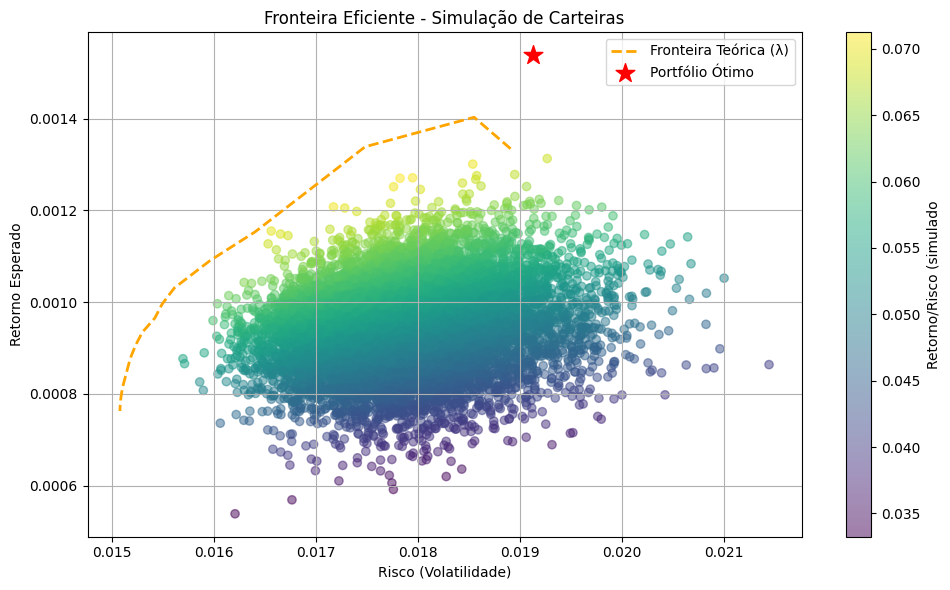

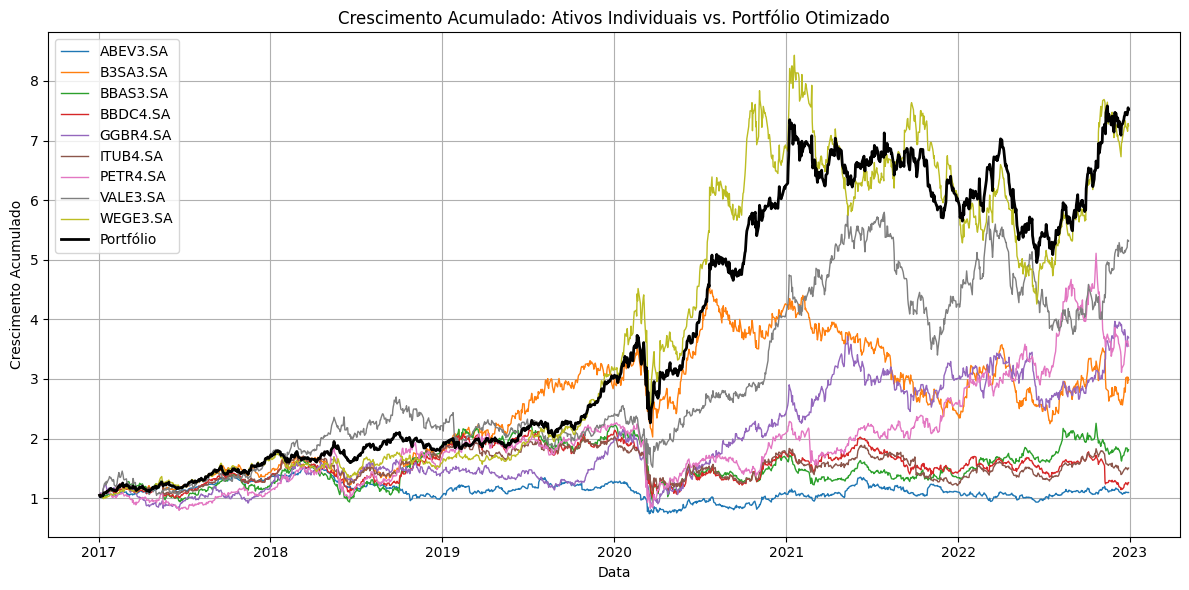


 Gráficos para Markowitz Monthly


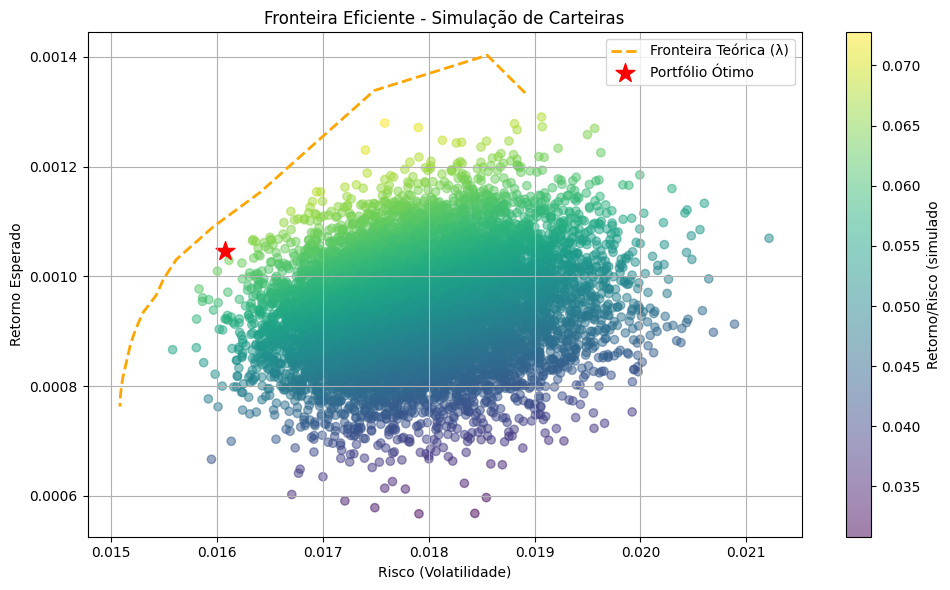

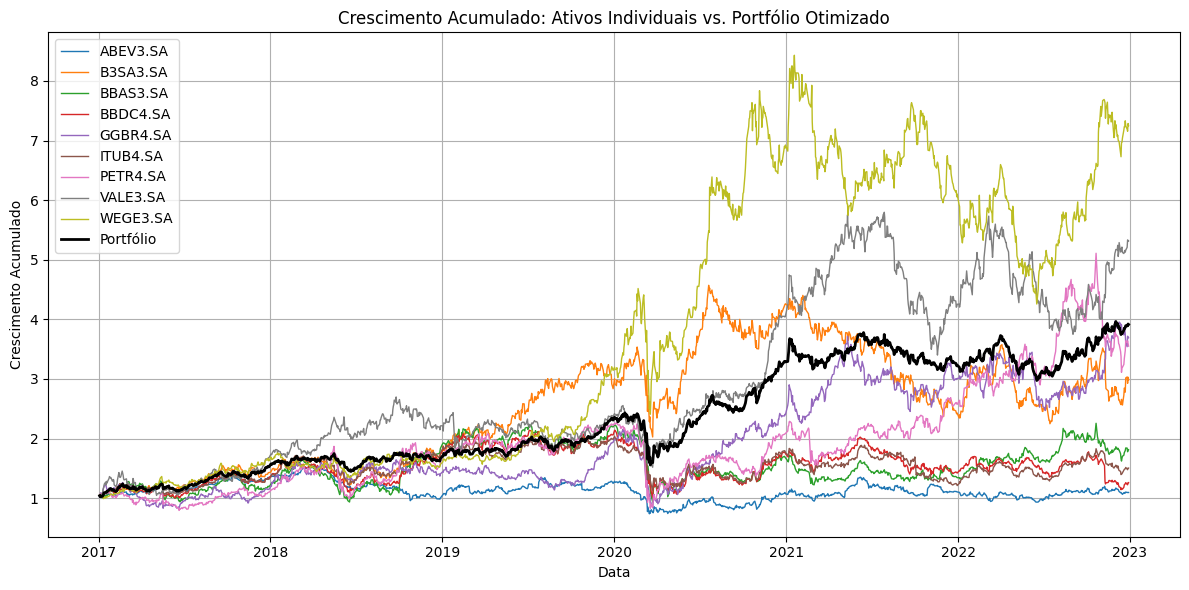


 Gráficos para Markowitz Daily


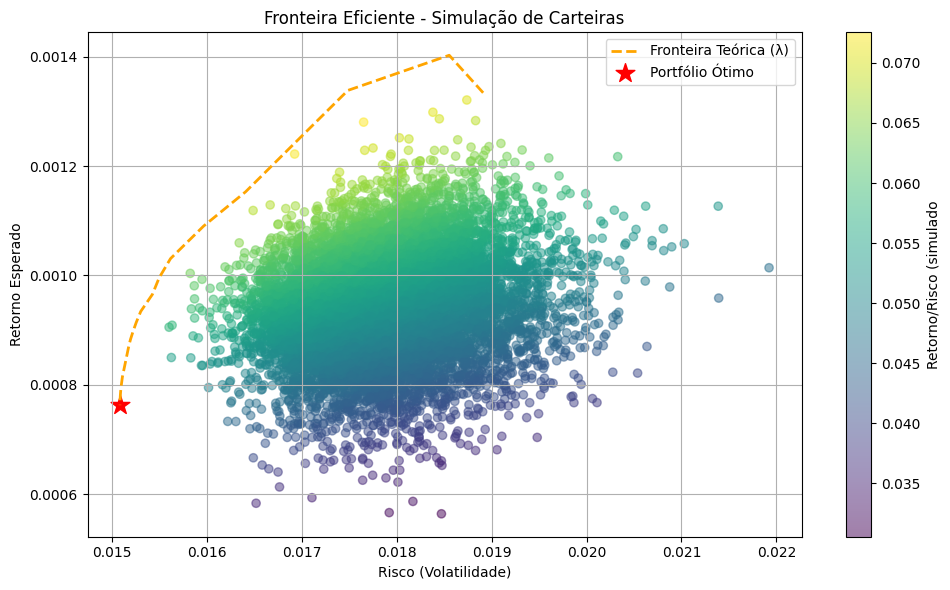

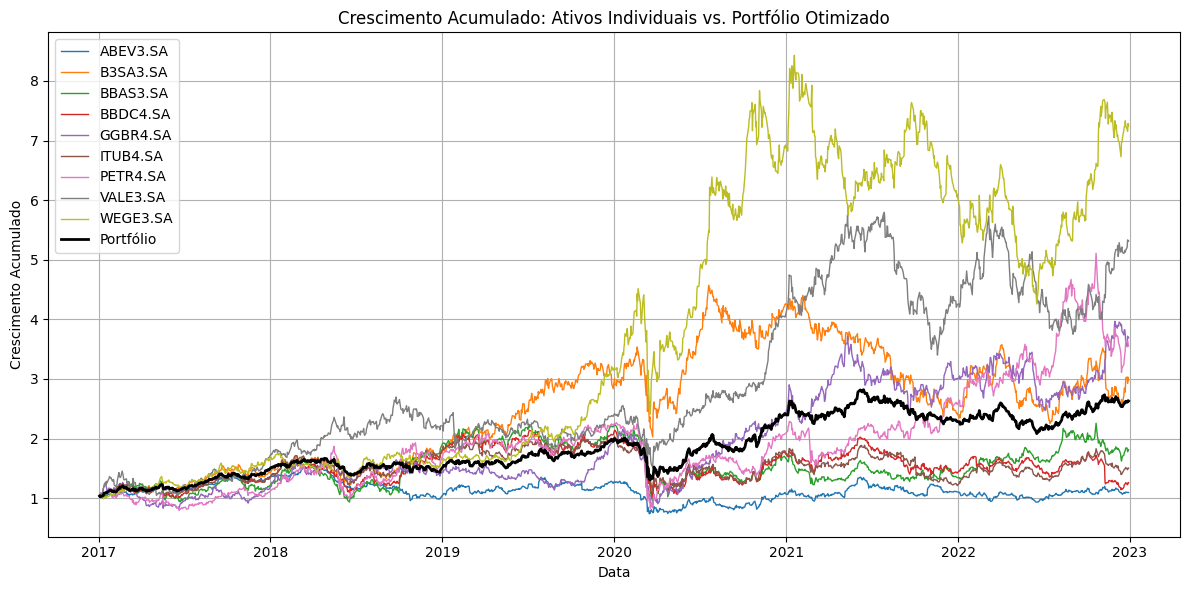

In [8]:
for nome, pesos in [("Sharpe", weights_sharpe), ("Markowitz Monthly", weights_markowitz_monthly), ("Markowitz Daily", weights_markowitz_daily)]:
    print(f"\n Gráficos para {nome}")
    plot_efficient_frontier(mean_returns_daily, cov_matrix_daily, optimized_weights=pesos)
    plot_time_serie(returns_daily, optimized_weights=pesos)

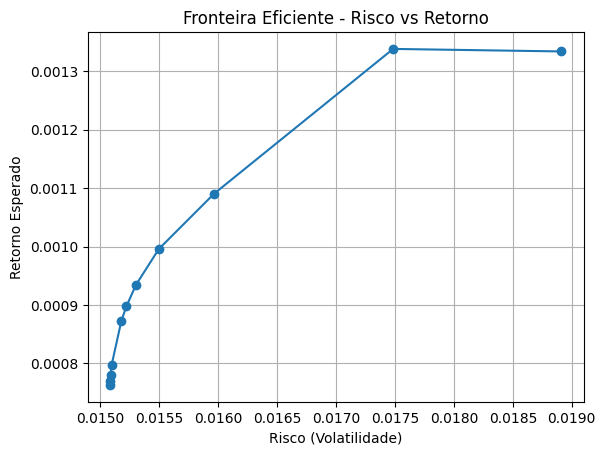

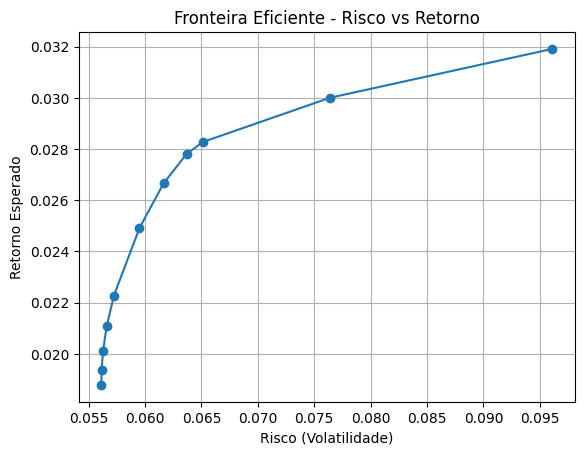

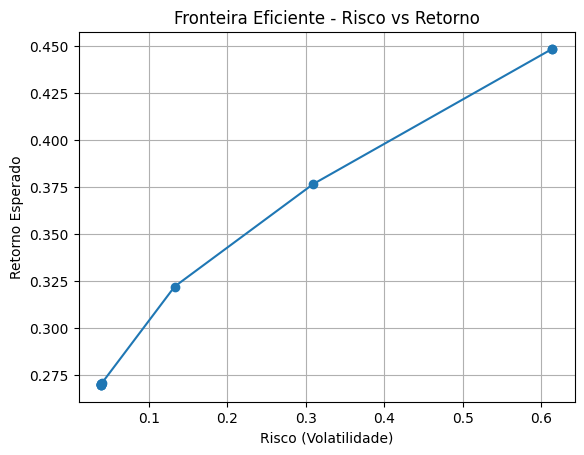

In [9]:
from outputs.charts.markowitz_plot import plot_frontier_line


ret_list_daily, vol_list_daily= markowitz_tradeoff(mean_returns_daily, cov_matrix_daily, interval=0.1)
ret_list_monthly, vol_list_monthly= markowitz_tradeoff(mean_returns_monthly, cov_matrix_monthly, interval=0.1)
ret_list_annually, vol_list_annually = markowitz_tradeoff(mean_returns_annually, cov_matrix_annually, interval=0.1)

# a parte mais a esquerde representa a fronteira de pareto
# a estimativa da medai tem q sair de uma rede neural
# gerando um preditor de media, a aprtir de retornos diarios anteriores
plot_frontier_line(vol_list_daily, ret_list_daily)
plot_frontier_line(vol_list_monthly, ret_list_monthly)
plot_frontier_line(vol_list_annually, ret_list_annually)

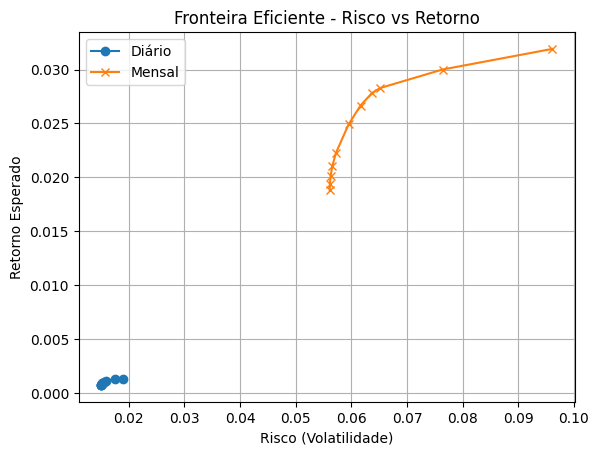

In [10]:
plt.plot(vol_list_daily, ret_list_daily, marker='o', label='Diário')
plt.plot(vol_list_monthly, ret_list_monthly, marker='x', label='Mensal')
plt.title("Fronteira Eficiente - Risco vs Retorno")
plt.xlabel("Risco (Volatilidade)")
plt.ylabel("Retorno Esperado")
plt.grid()
plt.legend()
plt.show()

In [11]:
# Converte fronteira diária para mensal e anual
ret_list_daily_to_monthly_acum, vol_list_daily_to_monthly_acum = [], []
ret_list_daily_to_annually_acum, vol_list_daily_to_annually_acum = [], []

for ret, vol in zip(ret_list_daily, vol_list_daily):
    ret_m, vol_m = converter_periodo(ret, vol, 21)
    ret_a, vol_a = converter_periodo(ret, vol, 252)
    ret_list_daily_to_monthly_acum.append(ret_m)
    vol_list_daily_to_monthly_acum.append(vol_m)
    ret_list_daily_to_annually_acum.append(ret_a)
    vol_list_daily_to_annually_acum.append(vol_a)


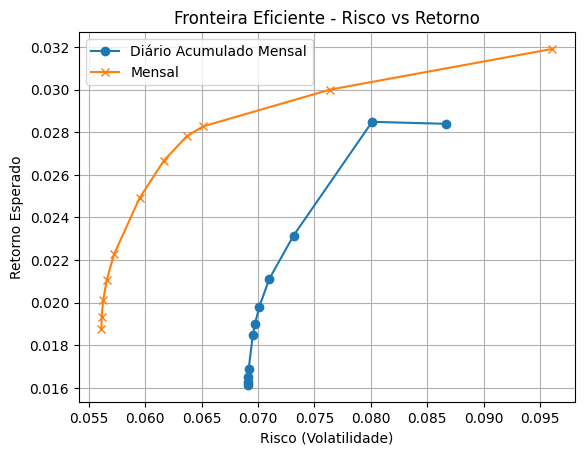

In [12]:
plt.plot(vol_list_daily_to_monthly_acum, ret_list_daily_to_monthly_acum, marker='o', label='Diário Acumulado Mensal')
plt.plot(vol_list_monthly, ret_list_monthly, marker='x', label='Mensal')
plt.title("Fronteira Eficiente - Risco vs Retorno")
plt.xlabel("Risco (Volatilidade)")
plt.ylabel("Retorno Esperado")
plt.grid()
plt.legend()
plt.show()

In [13]:
vol_list_daily_to_monthly_acum

[np.float64(0.08665534127332274),
 np.float64(0.08012230168255038),
 np.float64(0.07315642323234249),
 np.float64(0.07100727471169567),
 np.float64(0.07011946789265058),
 np.float64(0.06974628319430115),
 np.float64(0.06955045613288062),
 np.float64(0.06917396623652927),
 np.float64(0.06913316959218471),
 np.float64(0.06911971134376091),
 np.float64(0.06911718102550674)]

In [14]:
# Converte fronteira mensal para anual
ret_list_monthly_to_annually_acum, vol_list_monthly_to_annually_acum = [], []

for ret, vol in zip(ret_list_monthly, vol_list_monthly):
    ret_a, vol_a = converter_periodo(ret, vol, 12)  # 12 meses por ano
    ret_list_monthly_to_annually_acum.append(ret_a)
    vol_list_monthly_to_annually_acum.append(vol_a)

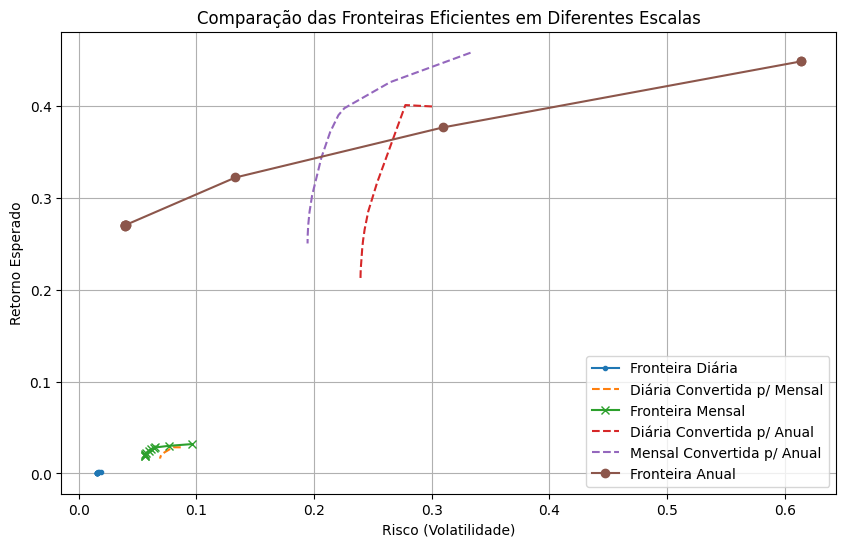

In [15]:
plt.figure(figsize=(10,6))
plt.plot(vol_list_daily, ret_list_daily, marker='.', label='Fronteira Diária')#
plt.plot(vol_list_daily_to_monthly_acum, ret_list_daily_to_monthly_acum, '--', label='Diária Convertida p/ Mensal')#
plt.plot(vol_list_monthly, ret_list_monthly, marker='x', label='Fronteira Mensal')#
plt.plot(vol_list_daily_to_annually_acum, ret_list_daily_to_annually_acum, '--', label='Diária Convertida p/ Anual')
plt.plot(vol_list_monthly_to_annually_acum, ret_list_monthly_to_annually_acum, '--', label='Mensal Convertida p/ Anual')
plt.plot(vol_list_annually, ret_list_annually, marker='o', label='Fronteira Anual')
plt.title("Comparação das Fronteiras Eficientes em Diferentes Escalas")
plt.xlabel("Risco (Volatilidade)")
plt.ylabel("Retorno Esperado")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
sharpe_individual = (mean_returns_daily - risk_free_rate_daily) / np.sqrt(np.diag(cov_matrix_daily))
ret_sharpe = portfolio_return(weights_sharpe, mean_returns_daily)
vol_sharpe = portfolio_volatility(weights_sharpe, cov_matrix_daily)
sharpe_ratio = (ret_sharpe - risk_free_rate_daily) / vol_sharpe

In [17]:
ret_sharpe_annual = (1 + ret_sharpe) ** 252 - 1
vol_sharpe_annual = vol_sharpe * np.sqrt(252)
sharpe_ratio_annual = sharpe_ratio * np.sqrt(252)

print(f"Retorno diário médio: {ret_sharpe:.6f}")
print(f"Volatilidade diária: {vol_sharpe:.6f}")
print(f"Sharpe diário: {sharpe_ratio:.6f}")
print("----")
print(f"Retorno anualizado: {ret_sharpe_annual:.2%}")


print(f"Volatilidade anualizada: {vol_sharpe_annual:.2%}")
print(f"Sharpe anualizado: {sharpe_ratio_annual:.3f}")

Retorno diário médio: 0.001538
Volatilidade diária: 0.019130
Sharpe diário: 0.051391
----
Retorno anualizado: 47.29%
Volatilidade anualizada: 30.37%
Sharpe anualizado: 0.816


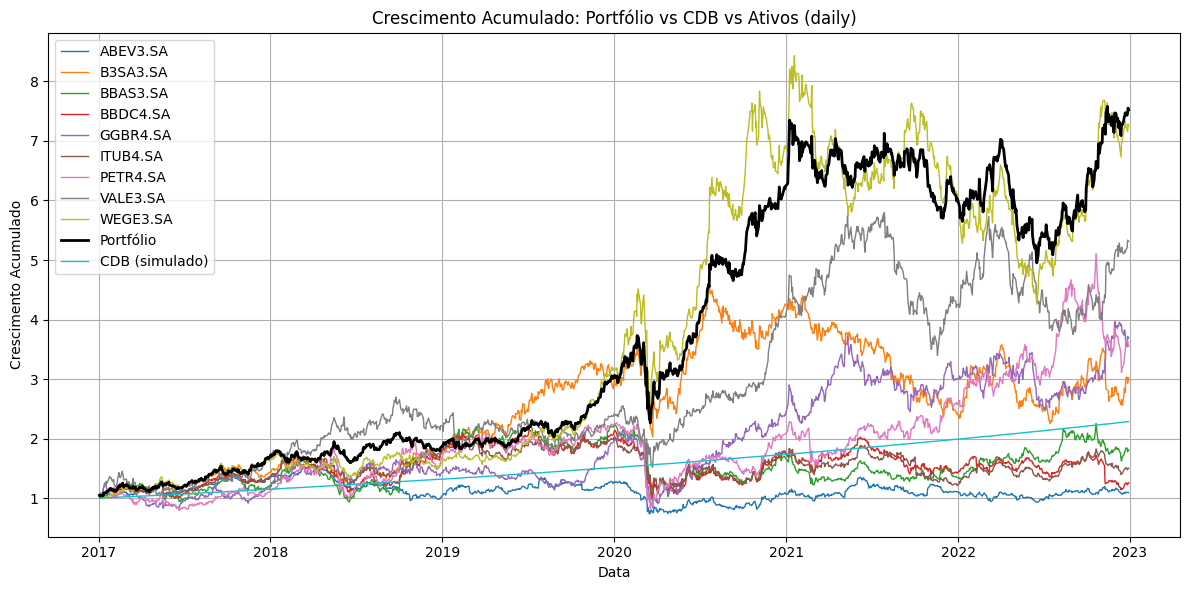

In [18]:
# === Benchmark comparativo (CDB/CDI) ===
from outputs.charts.markowitz_plot import compute_benchmark_growth

frequencia_retorno = 'daily'

# Número de períodos da série de retornos
num_periods = len(returns_daily)

# Crescimento acumulado do benchmark (CDB simulado)
cdb_growth = compute_benchmark_growth(risk_free_rate, frequencia_retorno, num_periods)

# === Retornos acumulados ===
returns_acumulados = (1 + returns_daily).cumprod()
returns_acumulados["Portfólio"] = (1 + returns_daily.dot(weights_sharpe)).cumprod()
returns_acumulados["CDB (simulado)"] = cdb_growth

plt.figure(figsize=(12, 6))
for col in returns_acumulados.columns:
    linewidth = 2 if col == "Portfólio" else 1
    color = "black" if col == "Portfólio" else None
    plt.plot(returns_acumulados.index, returns_acumulados[col],
             label=col, linestyle="-", linewidth=linewidth, color=color)

plt.title(f"Crescimento Acumulado: Portfólio vs CDB vs Ativos ({frequencia_retorno})")
plt.xlabel("Data")
plt.ylabel("Crescimento Acumulado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
target_return_daily = 0.023

target_return_monthly, vol_monthly = converter_periodo(target_return_daily, 0, 21)


In [20]:
lambda_daily = find_lambda_for_target(mean_returns_daily, cov_matrix_daily, target_return_daily)
lambda_monthly = find_lambda_for_target(mean_returns_monthly, cov_matrix_monthly, target_return_monthly)
#lambda_annually = find_lambda_for_target(mean_returns_annually, cov_matrix_annually, target_return)

In [21]:
weights_d = solve_markowitz(mean_returns_daily, cov_matrix_daily, lambda_daily)
weights_m = solve_markowitz(mean_returns_monthly, cov_matrix_monthly, lambda_monthly)
#weights_a = solve_markowitz(mean_returns_annually, cov_matrix_annually, lambda_annually)


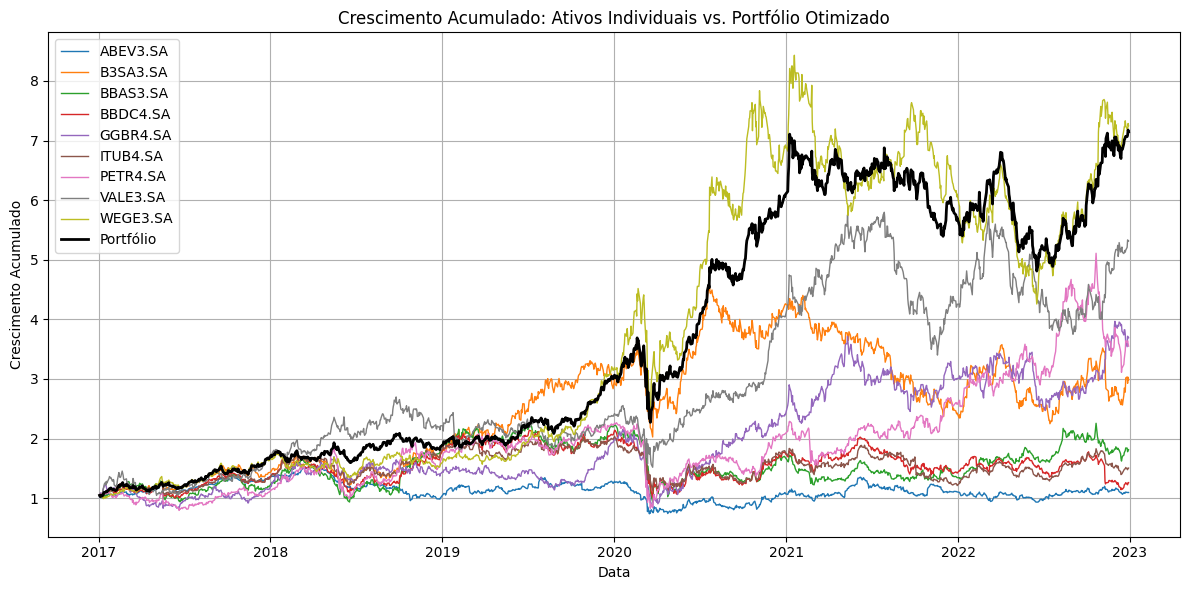

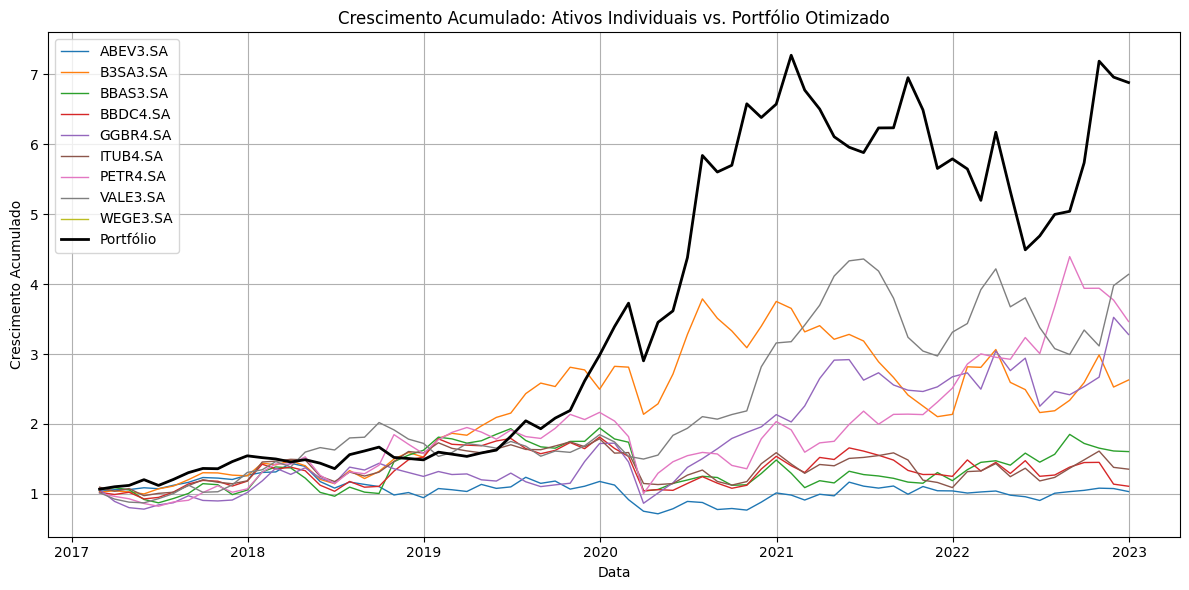

In [22]:
for nome, ret, w in [
    ('Diário', returns_daily, weights_d),
    ('Mensal', returns_monthly, weights_m),
    #('Anual', returns_annually, weights_a)
]:
    plot_time_serie(ret, w)

In [23]:
print(lambda_daily, lambda_monthly)#, lambda_annually)

0.09 0.0


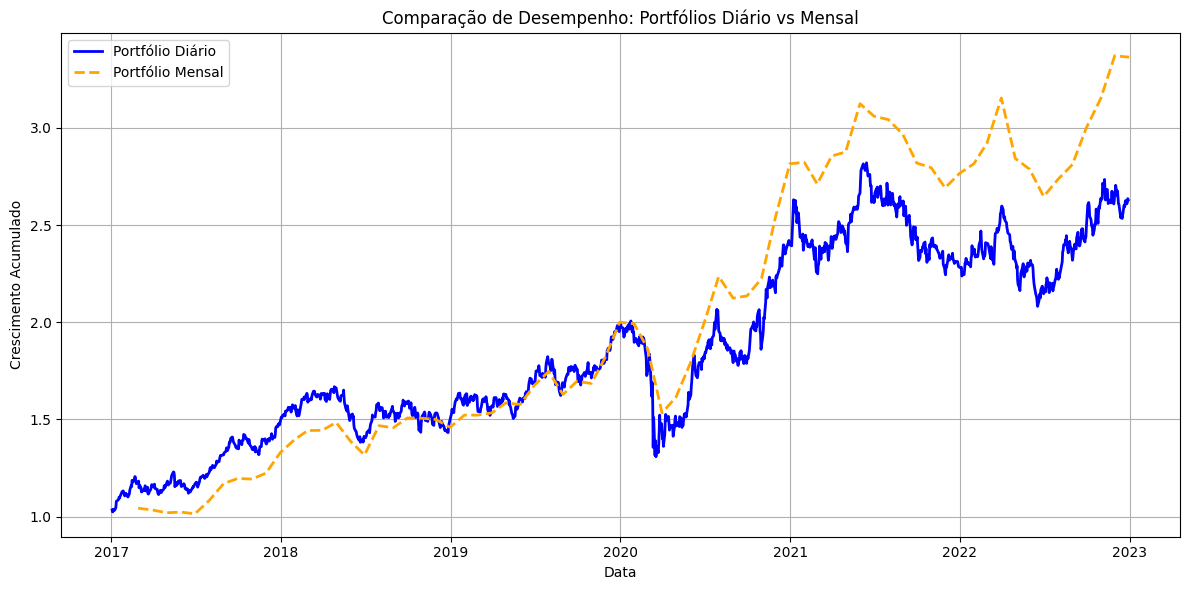

In [24]:
plot_comparison_time_series(
    returns_daily, returns_monthly,
    mean_returns_daily, cov_matrix_daily,
    mean_returns_monthly, cov_matrix_monthly
)

In [25]:
from src.optimization.evaluation import evaluate_portfolio


results_linear = evaluate_portfolio(
    returns=returns_daily,
    weights=weights_markowitz_daily,
    freq='daily',
    model_name='standard_markowitz',
)

pd.DataFrame([results_linear]).to_csv("../outputs/models/standard_markowitz.csv", index=False)